## Análise da Rede Social do GitHub
dataset: https://snap.stanford.edu/data/github-social.html<br>

Isabel de Castro Cordeiro, <br>
Email: icastrocordeiro@gmail.com<br>
LinkedIn: https://www.linkedin.com/in/isabel-castroc/<br>
Universidade Federal do Ceará, Fortaleza, Brasil.

In [1]:
! pip3 install torch_geometric
! pip3 install torch_sparse
! pip3 install torch_scatter

     |████████████████████████████████| 370 kB 9.7 MB/s 
     |████████████████████████████████| 482 kB 38.1 MB/s 
     |████████████████████████████████| 41 kB 515 kB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.3-py3-none-any.whl size=581968 sha256=9bab33b5287241abc22382869bafaa1cf9b56f97db71265d967c088dd7e4fdf2
  Stored in directory: /root/.cache/pip/wheels/c3/2a/58/87ce0508964d4def1aafb92750c4f3ac77038efd1b9a89dcf5
Successfully built torch-geometric
     |████████████████████████████████| 43 kB 1.2 MB/s 
  Created wheel for torch-sparse: filename=torch_sparse-0.6.12-cp37-cp37m-linux_x86_64.whl size=505740 sha256=7a20e7019b63758f17f00811859c2cc2b64ca98c9ec8c3596484ecf4ee173a3e
  Stored in directory: /root/.cache/pip/wheels/fb/e2/2f/44956c61e3299573ffe12da9d1374c7576ca0c5fb1fe1ed38c
Successfully built torch-sparse
  Created wheel for torch-scatter: filename=torch_scatter-2.0.9-cp37-cp37m-linux_x86_64.whl size=282116 sha256=ced9dc8f2d7acf9beced85ad79fdccbc0adbe

In [2]:
import json
import collections
import numpy as np
import pandas as pd
import math as math
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit as masking
from torch_geometric.utils.convert import to_networkx
from torch_geometric.nn import GCNConv

### Pré-processamento dos Dados

In [4]:
with open("data/musae_git_features.json") as json_data:
    data_raw = json.load(json_data)
    
target = pd.read_csv("data/musae_git_target.csv")
edges = pd.read_csv("data/musae_git_edges.csv")

In [ ]:
target

,id,name,ml_target
0,0,Eiryyy,0
1,1,shawflying,0
2,2,JpMCarrilho,1
3,3,SuhwanCha,0
4,4,sunilangadi2,1
...,...,...,...
37695,37695,shawnwanderson,1
37696,37696,kris-ipeh,0
37697,37697,qpautrat,0
37698,37698,Injabie3,1


In [5]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37700 entries, 0 to 37699
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         37700 non-null  int64 
 1   name       37700 non-null  object
 2   ml_target  37700 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 883.7+ KB


In [6]:
target['ml_target'].value_counts()

0    27961
1     9739
Name: ml_target, dtype: int64

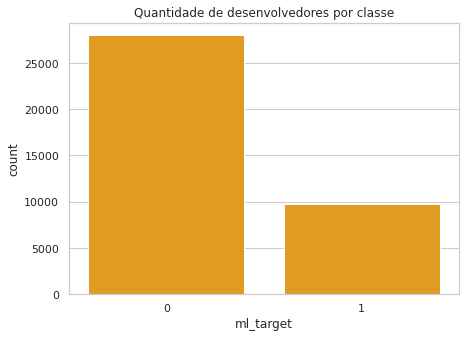

In [7]:
sns.set(style="whitegrid")
plt.figure(figsize=(7,5))
plt.title('Quantidade de desenvolvedores por classe')
sns.countplot(x="ml_target", color = 'orange', data=target)
plt.show()


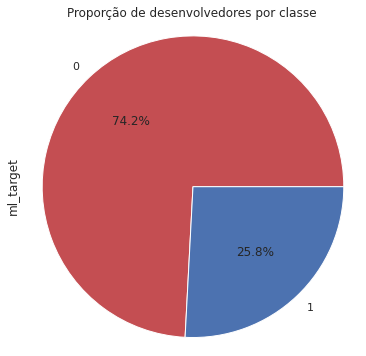

In [8]:
plt.title('Proporção de desenvolvedores por classe')
target.ml_target.value_counts().plot(kind='pie',colors = ('r','b'), autopct='%.1f%%',figsize=(6,6))
plt.axis('equal')
plt.show()

### Estrutura da Rede

Aqui avaliamos a estrutura da rede a partir do arquivo que contém a lista de arestas.

In [9]:
edges

,id_1,id_2
0,0,23977
1,1,34526
2,1,2370
3,1,14683
4,1,29982
...,...,...
288998,37527,37596
288999,37529,37601
289000,37644,2347
289001,25879,2347


In [10]:
edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289003 entries, 0 to 289002
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   id_1    289003 non-null  int64
 1   id_2    289003 non-null  int64
dtypes: int64(2)
memory usage: 4.4 MB


A densidade $D$ de uma rede é definida como uma relação entre o número de arestas $E$ para o número de arestas possíveis, dada por 
$ D = \frac{2E}{N(N-1)}$

In [11]:
G = nx.read_edgelist("data/musae_git_edges.txt", nodetype = int)
print(nx.info(G))
print("Density:", "%3.4f"%nx.density(G))

Graph with 37700 nodes and 289003 edges
Density: 0.0004


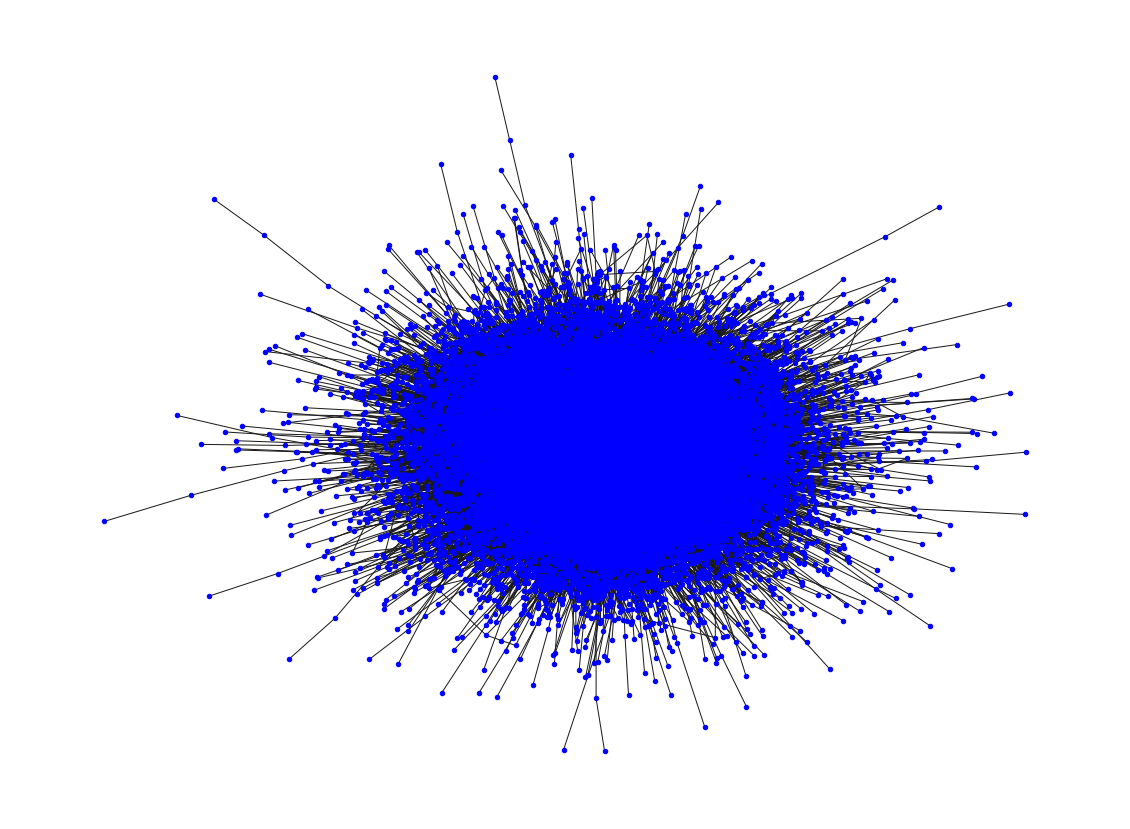

In [12]:
pos = nx.spring_layout(G)
plt.rcParams['figure.figsize'] = (20, 15)
plt.axis('off')

nx.draw(G, pos, node_color = "blue", node_size = 20, with_labels = False)
plt.savefig("graph.png")

### Medidas relacionadas ao grau

O grau $k$ de um nó é o número de arestas conectadas a ele.

O grau médio da rede:

In [13]:
vk = dict(G.degree())
vk = dict(sorted(vk.items()))
vk = list(vk.values())
vk = np.array(vk)
print(vk)

md = np.mean(vk)
print('Mean degree: ', "%3.4f"%md)

[1 8 1 ... 4 3 4]
Mean degree:  15.3317


A partir dos graus dos nós, podemos calcular várias medidas estatísticas. Desenvolvemos uma função para calcular a distribuição de graus e representamos graficamente a distribuição de graus em escala log-log.

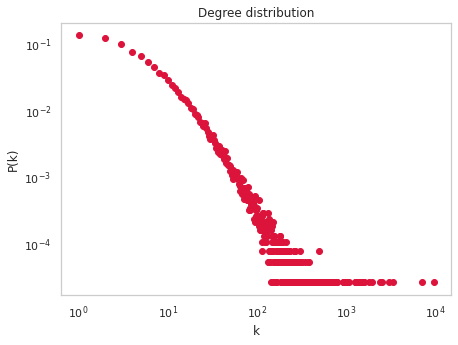

In [14]:
def degree_distribution(G):
    vk = dict(G.degree())
    vk = dict(sorted(vk.items()))
    vk = list(vk.values())  # we get only the degree values
    vk = np.array(vk)
    maxk = np.max(vk)
    mink = np.min(vk)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    return kvalues,Pk

ks, Pk = degree_distribution(G)

plt.figure(figsize=(7,5))
plt.xscale('log')
plt.yscale('log')
plt.plot(ks,Pk,'o',color = 'crimson')
plt.xlabel("k")
plt.ylabel("P(k)")
plt.title("Degree distribution")
plt.grid(False)
plt.show()

O nível de heterogeneidade da rede em relação ao número de conexões pode ser quantificado pela entropia de Shannon. Uma função para calcular a entropia de Shannon da distribuição de graus pode ser definida como:

In [15]:
def shannon_entropy(G):
    k,Pk = degree_distribution(G)
    H = 0
    for p in Pk:
        if(p > 0):
            H = H - p*math.log(p, 2)
    return H

H = shannon_entropy(G)
print("Shannon Entropy = ", "%3.4f"%H)

Shannon Entropy =  4.8587


### Coeficiente de clusterização

O coeficiente de agregação é uma medida de propriedade "all-my-friends-know-each-other". Isso é algumas vezes descrito como os amigos dos meus amigos são meus amigos. Mais precisamente, o coeficiente de agregação de um nó é o rácio entre os ligações existentes conectando os vizinhos do nó uns aos outros para o maior número possível de tais ligações. O coeficiente de agregação para toda a rede é a média dos coeficientes de todos os nós de agregação. 

In [16]:
avc = nx.average_clustering(G)
print("Average clustering:", "%3.4f"%avc)

Average clustering: 0.1675


O agrupamento de cada nó é definido pela fração de arestas entre os vizinhos de cada nó.<br>
Isto é, o coeficiente de agregação do nó $i$ é $C_i = \frac{2e_i}{k_i (k_i-1)}$, onde $k_i$ é o número de vizinhos do nó $i$, e $e_i$ é o número de conexões entre esses vizinhos. O maior número possível de conexões entre vizinhos é, naturalmente, $\frac{k(k-1)}{2}$.

In [17]:
vcc = []
for i in sorted(G.nodes()):
    vcc.append(nx.clustering(G, i))
vcc = np.array(vcc)
print('Clustering of all nodes:', vcc)

Clustering of all nodes: [0.         0.17857143 0.         ... 0.         0.         0.33333333]


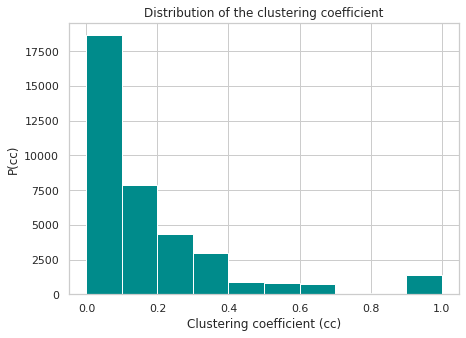

In [18]:
plt.figure(figsize=(7,5))
plt.hist(vcc, bins = 10, color = 'darkcyan')
plt.title("Distribution of the clustering coefficient")
plt.ylabel("P(cc)")
plt.xlabel("Clustering coefficient (cc)")
plt.grid(True)
plt.show()

### Diâmetro

Como outro meio de medir grafos de rede, podemos definir o diâmetro de uma rede como o mais longo de todos os caminhos mais curtos calculados numa rede. Por outras palavras, uma vez que o menor comprimento do caminho de cada nó para todos os outros nós é calculado, o diâmetro é o mais longo de todos os comprimentos do caminho calculado. O diâmetro é representante do tamanho de uma rede. 

In [19]:
d = nx.diameter(G)
print('Network diameter:', d)

Network diameter: 11


Outra medida relacionada às distâncias é a eficiência da rede, que é uma medida da eficiência das trocas de informações da rede. A eficiência global média de um gráfico é a eficiência média de todos os pares de nós. Quanto maior for essa medida, melhor será a transmissão de informações em uma rede.

In [20]:
E = nx.global_efficiency(G)
print('Network efficiency', "%3.4f"%E)

Network efficiency 0.3259


### Centralidade
Informações sobre a importância relativa de nós e arestas num grafo podem ser obtidas através de medidas de centralidade. A centralidade de um nó pode ser vista como uma medida da influência ou importância num modelo de rede. O objetivo da análise da rede geralmente determina o tipo de centralidades a ser usado.

**Closeness centrality**

Em um gráfico conectado, a *centralidade de proximidade* (ou proximidade) de um nó é uma medida de centralidade em uma rede, calculada como o recíproco da soma do comprimento dos caminhos mais curtos entre o nó e todos os outros nós no gráfico. Assim, quanto mais central um nó, mais próximo ele está de todos os outros nós.

In [21]:
CLC = dict(nx.closeness_centrality(G))
CLC = dict(sorted(CLC.items()))
print('Closeness centrality', CLC)

Closeness centrality {0: 0.27502662795278465, 1: 0.2949797342764589, 2: 0.261865896098303, 3: 0.27873979652194486, 4: 0.2431032926215871, 5: 0.34343940456777416, 6: 0.37227329732291864, 7: 0.32022662793265716, 8: 0.3515615528801768, 9: 0.34361783578824556, 10: 0.39077659839124307, 11: 0.3715285306001774, 12: 0.30126181704851485, 13: 0.35147960991254734, 14: 0.3240611004616059, 15: 0.38497829971917286, 16: 0.3091374263011587, 17: 0.28768419526414996, 18: 0.3436147038181437, 19: 0.3275496550645559, 20: 0.28892107723670696, 21: 0.3789796431264137, 22: 0.3238634411188619, 23: 0.34732817394508936, 24: 0.3337671536077911, 25: 0.35074383856051655, 26: 0.3483680786574998, 27: 0.32096820883069116, 28: 0.21094007911861637, 29: 0.3490712790977611, 30: 0.33186031567179286, 31: 0.3422732266235712, 32: 0.27603148453230825, 33: 0.2763977887590363, 34: 0.266269723552429, 35: 0.3585668359679659, 36: 0.32947335302651587, 37: 0.2599052733903715, 38: 0.3926447460239759, 39: 0.29705068906556564, 40: 0.3448

In [22]:
CLC = list(CLC.values())
av_clc = np.mean(CLC)
print('Average closeness centrality', "%3.4f"%av_clc)

Average closeness centrality 0.3137


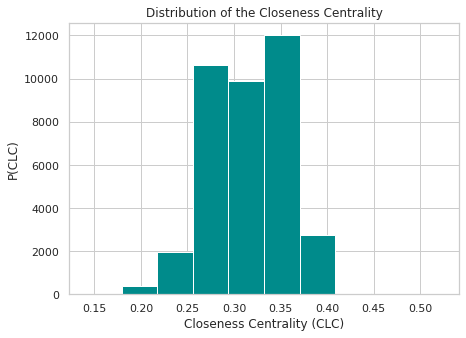

In [ ]:
plt.figure(figsize=(7,5))
plt.hist(CLC, color = 'darkcyan')
plt.title("Distribution of the Closeness Centrality")
plt.ylabel("P(CLC)")
plt.xlabel("Closeness Centrality (CLC)")
plt.show(True)

### Exploração dos Atributos

In [23]:
for key,value in data_raw.items():
    print(key, value)

A saída de streaming foi truncada nas últimas 5000 linhas.
32700 [1574, 3773, 3214, 2672, 2271, 3291, 3129, 1852, 3077, 1171, 3763, 2045, 536, 1764, 2590, 1532, 2472, 1348, 3028, 1355, 1606, 2033, 3591]
32701 [3035, 2527, 1663, 3129, 1852, 3077, 364, 1171, 1022, 3763, 2045, 536, 3443, 1532, 3771, 1348, 1882, 2250, 2209, 2387, 695, 3534, 1001]
32702 [3433, 3773, 3104, 3913, 3129, 1022, 3763, 536, 3567, 2402, 1532, 2472, 3794, 1001]
32703 [3964, 354, 3214, 983, 3077, 1171, 1022, 2045, 536, 3175, 423, 1532, 3771, 3794, 1001, 35, 2387, 274]
32704 [3964, 333, 73, 2827, 3129, 3077, 3763, 2045, 536, 128, 3771, 234, 2958, 2461]
32705 [1929, 3773, 925, 1107, 2963, 3129, 1852, 3077, 1171, 1022, 3763, 2045, 536, 85, 3811, 1532, 2472, 234, 703, 1001]
32706 [1286, 224, 1793, 1392, 1852, 3077, 364, 1171, 1022, 3763, 256, 3749, 2007, 1532, 2472, 1122]
32707 [1286, 3233, 3214, 144, 3129, 1852, 3077, 364, 1171, 1022, 2045, 536, 1336, 39, 1532, 2472, 3794, 343]
32708 [3964, 3773, 73, 290, 3077, 364, 117

In [24]:
feats=[]
feat_counts=[]
for i in range(len(data_raw)):
    feat_counts+=[len(data_raw[str(i)])]
    feats+=data_raw[str(i)]
    
print("Número de atributos:",max(feats)+1)

Número de atributos: 4005


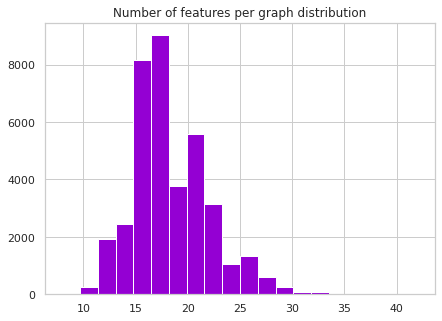

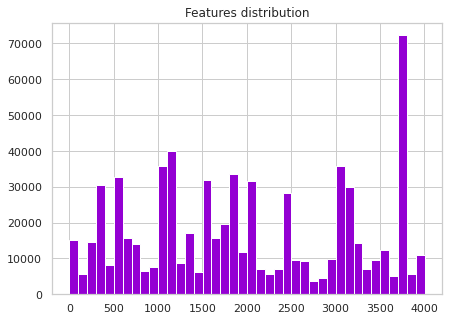

In [25]:
plt.figure(figsize=(7,5))
plt.hist(feat_counts, bins = 20, color = 'darkviolet')
plt.title("Number of features per graph distribution")
plt.show()

plt.figure(figsize=(7,5))
plt.hist(feats, bins = 40, color = 'darkviolet')
plt.title("Features distribution")
plt.show()

Os atributos dos nós nos dizem qual recurso está anexado a cada nó. É possível codificar esses recursos atributos na função `encode_data`. O objetivo é usar essa função para codificar um subconjunto leve do gráfico (por exemplo, apenas 60 nós) para fins de visualização.

In [26]:
def encode_data(light=False,n=60):
    if light==True:
        nodes_included=n
    elif light==False:
        nodes_included=len(data_raw)
    data_encoded={}
    for i in range(nodes_included):# 
        one_hot_feat=np.array([0]*(max(feats)+1))
        this_feat=data_raw[str(i)]
        one_hot_feat[this_feat]=1
        data_encoded[str(i)]=list(one_hot_feat)
    if light==True:
        sparse_feat_matrix=np.zeros((1,max(feats)+1))
        for j in range(nodes_included):
            temp=np.array(data_encoded[str(j)]).reshape(1,-1)
            sparse_feat_matrix=np.concatenate((sparse_feat_matrix,temp),axis=0)
        sparse_feat_matrix=sparse_feat_matrix[1:,:]
        return(data_encoded,sparse_feat_matrix)
    elif light==False:
        return(data_encoded, None)

Podemos plotar as primeiras 250 colunas de atributos (o total é 4005) do código para os primeiros 60 usuários. Abaixo, podemos visualizar o quão esparsa é a matriz que construímos para os atributos dos nós. 

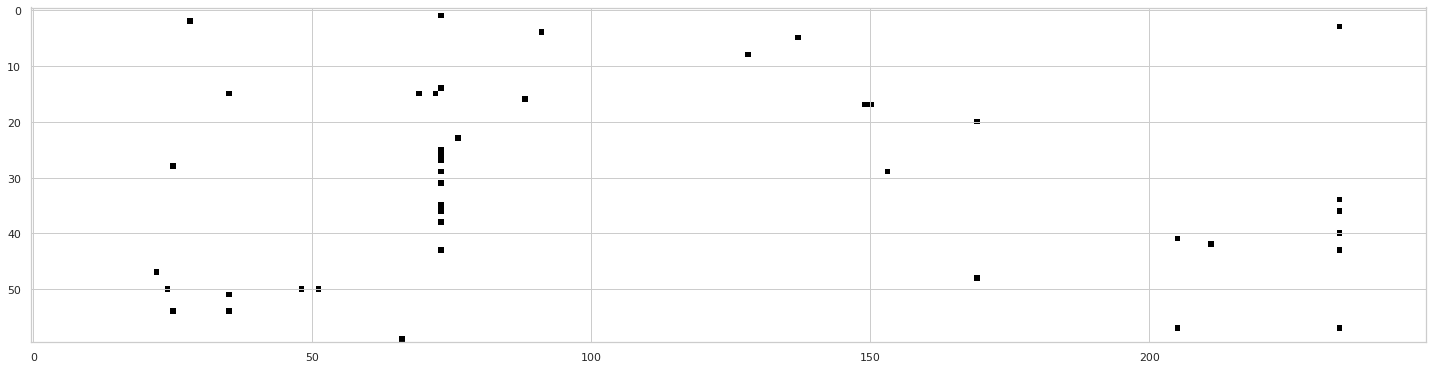

In [27]:
data_encoded_vis,sparse_feat_matrix_vis=encode_data(light=True,n=60)
plt.figure(figsize=(25,25))
plt.imshow(sparse_feat_matrix_vis[:,:250],cmap='Greys')
plt.show()

Para construir o grafo, usamos o `torch_geometric.data.Data`, que é um objeto Python simples para modelar um único grafo com vários atributos (opcionais). Construimos o grafo usando esta classe e passando os seguintes atributos:

- **x**: será atribuído aos recursos do nó codificado, seu formato é `[número_de_nós, número_de_características]`. 

- **y**: será atribuído aos rótulos dos nós, sua forma é `[número_de_nós] `

- **edge_index**: para representar um grafo não direcionado, precisamos estender os índices das arestas originais de uma forma que possamos ter duas arestas direcionadas separadas conectando os mesmos dois nós, mas apontando na direção oposta um ao outro. Esta é uma maneira de representar o grafo não direcionado se tivermos os índices das arestas. A forma do tensor será `[2,2 * number_of_original_edges]`.

In [28]:
def construct_graph(data_encoded,light=False):
    node_features_list=list(data_encoded.values())
    node_features=torch.tensor(node_features_list)
    node_labels=torch.tensor(target['ml_target'].values)
    edges_list=edges.values.tolist()
    edge_index01=torch.tensor(edges_list, dtype = torch.long).T
    edge_index02=torch.zeros(edge_index01.shape, dtype = torch.long)#.T
    edge_index02[0,:]=edge_index01[1,:]
    edge_index02[1,:]=edge_index01[0,:]
    edge_index0=torch.cat((edge_index01,edge_index02),axis=1)
    g = Data(x=node_features, y=node_labels, edge_index=edge_index0)
    g_light = Data(x=node_features[:,0:2],
                     y=node_labels   ,
                     edge_index=edge_index0[:,:55])
    if light:
        return(g_light)
    else:
        return(g)

Para desenhar um grafo, temos a função `draw_graph`.

In [29]:
def draw_graph(data0):
    #node_labels=data0.y
    if data0.num_nodes>100:
        print("This is a big graph, can not plot...")
        return
    else:
        data_nx = to_networkx(data0)
        node_colors=data0.y[list(data_nx.nodes)]
        pos= nx.spring_layout(data_nx,scale =1)
        plt.figure(figsize=(12,8))
        nx.draw(data_nx, pos,  cmap=plt.get_cmap('Set1'),
                node_color=node_colors,node_size=400,connectionstyle="angle3",
                width=1, with_labels = False, edge_color = 'k', arrowstyle = "-")

Agora, é possível desenhar um subgrafo chamando` construct_graph `com `light=True.` Então podemos passá-lo para `draw_graph`, para mostrar o grafo a seguir. Pode-se ver como os nós são conectados por arestas e rotulados por cores. 

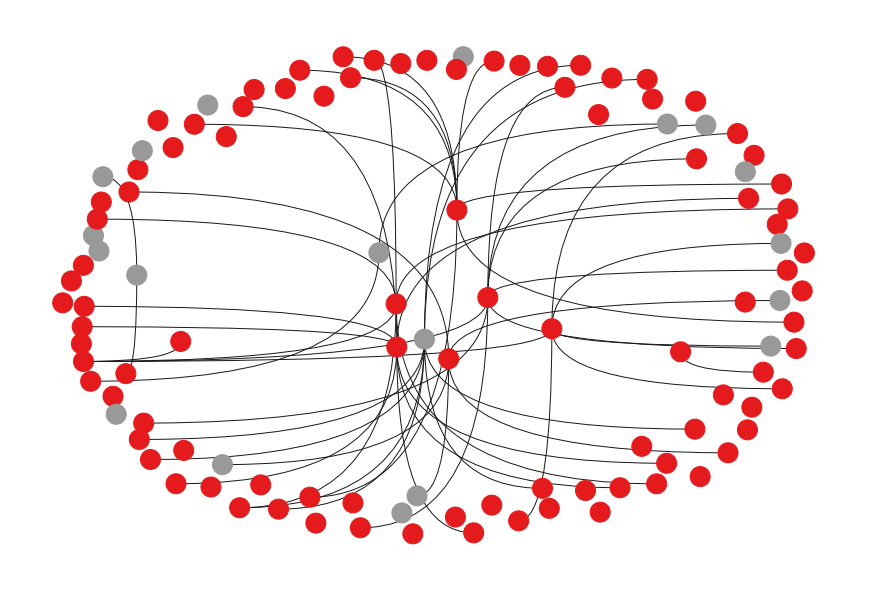

In [30]:
g_sample=construct_graph(data_encoded=data_encoded_vis,light=True)
draw_graph(g_sample)

### Construção e treinamento do modelo GNN 

Começamos codificando todos os dados chamando `encode_data` com `light=False` e construímos o grafo completo chamando `construct_graph` com `light=False`. A visualização completa desse grafo pode ser encontrada nas células acima.

In [31]:
data_encoded,_=encode_data(light=False)
g=construct_graph(data_encoded=data_encoded,light=False)

A etapa imediata após a preparação dos dados para o modelo é a divisão dos dados em subconjuntos para treinar o modelo e validar o seu desempenho em relação aos novos, e por último um segmento de teste para relatar o desempenho geral.

A divisão de um grafo não é direta, pois temos um único grafo muito grande. Para indicar na fase de treinamento quais nós devem ser incluídos para treinamento e na fase de inferência quais nós farão parte dos dados de teste, é possível utilizar máscaras que são vetores binários que indicam (usando 0 e 1) quais nós pertencem a cada máscara em particular.

A classe `torch_geometric.transforms.AddTrainValTestMask` pega nosso grafo e define como queremos que nossas máscaras sejam formadas e adiciona uma divisão de nível de nó por meio dos atributos `train_mask`,` val_mask` e `test_mask`.


No treinamento, usamos 30% como conjunto de validação e 30% como conjunto de teste enquanto mantemos apenas 40% para o treinamento. 
 
Também podemos imprimir as informações do grafo e o número de nós de cada conjunto (máscara). Os números entre colchetes são a forma de cada tensor de atributo.

In [72]:
msk=masking(split="train_rest", num_splits = 1, num_val = 0.3, num_test= 0.3)
g=msk(g)
print(g)
print()
print("training samples",torch.sum(g.train_mask).item())
print("validation samples",torch.sum(g.val_mask ).item())
print("test samples",torch.sum(g.test_mask ).item())

Data(x=[37700, 4005], edge_index=[2, 578006], y=[37700], train_mask=[37700], val_mask=[37700], test_mask=[37700])

training samples 15080
validation samples 11310
test samples 11310


Nesse ponto, podemos construir a classe modelo GNN. Para isso, será usada a classe `torch_geometric.nn.GCNConv`.

Empilharemos duas camadas GCNConv, a primeira tem entrada igual ao número de atributos do grafo e algum número arbitrário de features de saída `f`. Em seguida, aplicamos uma função de ativação `leaky_relu` e entregamos os recursos latentes à segunda camada, que tem nós de saída iguais ao número de classes (ou seja, 2).



In [115]:
class SocialGNN(torch.nn.Module):
    def __init__(self,num_of_feat,f):
        super(SocialGNN, self).__init__()
        self.conv1 = GCNConv(num_of_feat, f)
        self.conv2 = GCNConv(f, 2)
    def forward(self, data):
        x = data.x.float()
        edge_index =  data.edge_index
        x = self.conv1(x=x, edge_index=edge_index)
        x = F.leaky_relu(x)
        x = self.conv2(x, edge_index)
        return x

Como o modelo irá prever a classe de todos os vértices do grafo, nós, no entanto, queremos calcular a perda e a precisão para um conjunto específico com base na fase em que estamos. Por exemplo, durante o treinamento, queremos calcular a perda e a precisão do treinamento apenas com base no conjunto de treinamento e é aqui onde devemos usar as máscaras. Vamos definir as funções `masked_loss` e `masked_accuracy` para as quais passamos as respectivas máscaras e as mesmas retornam a perda e a precisão correspondentes. A ideia é calcular a perda e a precisão de todos os nós e multiplicá-los pela máscara para zerar os nós não necessários.

In [76]:
def masked_loss(predictions,labels,mask):
    mask=mask.float()
    mask=mask/torch.mean(mask)
    loss=criterion(predictions,labels)
    loss=loss*mask
    loss=torch.mean(loss)
    return (loss)    
def masked_accuracy(predictions,labels,mask):
    mask=mask.float()
    mask/=torch.mean(mask)
    accuracy=(torch.argmax(predictions,axis=1)==labels).long()
    accuracy=mask*accuracy
    accuracy=torch.mean(accuracy)
    return (accuracy)

Aqui, podemos definir nossa função de treinamento na qual usaremos o otimizador `torch.optim.Adam`. Executaremos o treinamento por um certo número de épocas e acompanharemos para obter a melhor precisão de validação. Também representamos as perdas e as precisões ao longo das épocas do treinamento. 

In [105]:
def train_social(net,data,epochs=10,lr=0.01):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr) # 00001
    best_accuracy=0.0
    train_losses=[]
    train_accuracies=[]
    val_losses=[]
    val_accuracies=[]
    test_losses=[]
    test_accuracies=[]
    for ep in range(epochs+1):
        optimizer.zero_grad()
        out=net(data)
        loss=masked_loss(predictions=out,
                         labels=data.y,
                         mask=data.train_mask)
        loss.backward()
        optimizer.step()
        train_losses+=[loss]
        train_accuracy=masked_accuracy(predictions=out,
                                       labels=data.y, 
                                       mask=data.train_mask)
        train_accuracies+=[train_accuracy]
        val_loss=masked_loss(predictions=out,
                             labels=data.y, 
                             mask=data.val_mask)
        val_losses+=[val_loss]
        val_accuracy=masked_accuracy(predictions=out,
                                     labels=data.y, 
                                     mask=data.val_mask)
        val_accuracies+=[val_accuracy]
        test_accuracy=masked_accuracy(predictions=out,
                                      labels=data.y, 
                                      mask=data.test_mask)
        test_accuracies+=[test_accuracy]
        if np.round(val_accuracy,4)> np.round(best_accuracy ,4):
            print("Epoch {}/{}, Train_Loss: {:.4f}, Train_Accuracy: {:.4f}, Val_Accuracy: {:.4f}, Test_Accuracy: {:.4f}"
                      .format(ep+1,epochs, loss.item(), train_accuracy, val_accuracy,  test_accuracy))
            best_accuracy=val_accuracy
    plt.figure(figsize=(12,8))
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.plot(test_losses)
    plt.legend(['Train_Loss','Val_Loss','Test_Loss'])
    plt.show()
    plt.figure(figsize=(12,8))
    plt.plot(train_accuracies,label='Train_Accuracy') 
    plt.plot(val_accuracies,label='Val_Accuracy')
    plt.plot(test_accuracies,label='Test_Accuracy')
    plt.legend(['Train_Accuracy','Val_Accuracy','Test_Accuracy'])
    plt.show()

Neste ponto, temos todas as funções necessárias e estamos prontos para instanciar nosso modelo e treiná-lo. Construiremos o modelo com 16 filtros e usaremos `nn.CrossEntropyLoss` como nosso critério de perda. Por fim, podemos ver que nosso modelo simples atingiu uma precisão muito decente no conjunto de teste, mais de 91%. Também podemos ver as curvas de aprendizagem (perdas) e o desenvolvimento de acurácias ao longo das épocas nos gráficos superior e inferior, respectivamente

Epoch 1/200, Train_Loss: 0.7195, Train_Accuracy: 0.2580, Val_Accuracy: 0.2578, Test_Accuracy: 0.2596
Epoch 2/200, Train_Loss: 0.7672, Train_Accuracy: 0.7416, Val_Accuracy: 0.7425, Test_Accuracy: 0.7408
Epoch 3/200, Train_Loss: 0.4984, Train_Accuracy: 0.7422, Val_Accuracy: 0.7430, Test_Accuracy: 0.7413
Epoch 4/200, Train_Loss: 0.5045, Train_Accuracy: 0.7489, Val_Accuracy: 0.7473, Test_Accuracy: 0.7472
Epoch 5/200, Train_Loss: 0.4898, Train_Accuracy: 0.8138, Val_Accuracy: 0.8095, Test_Accuracy: 0.8142
Epoch 6/200, Train_Loss: 0.4433, Train_Accuracy: 0.8611, Val_Accuracy: 0.8557, Test_Accuracy: 0.8609
Epoch 8/200, Train_Loss: 0.3626, Train_Accuracy: 0.8627, Val_Accuracy: 0.8566, Test_Accuracy: 0.8622
Epoch 12/200, Train_Loss: 0.3643, Train_Accuracy: 0.8627, Val_Accuracy: 0.8580, Test_Accuracy: 0.8626
Epoch 13/200, Train_Loss: 0.3565, Train_Accuracy: 0.8687, Val_Accuracy: 0.8642, Test_Accuracy: 0.8698
Epoch 16/200, Train_Loss: 0.3517, Train_Accuracy: 0.8712, Val_Accuracy: 0.8645, Test_Accu

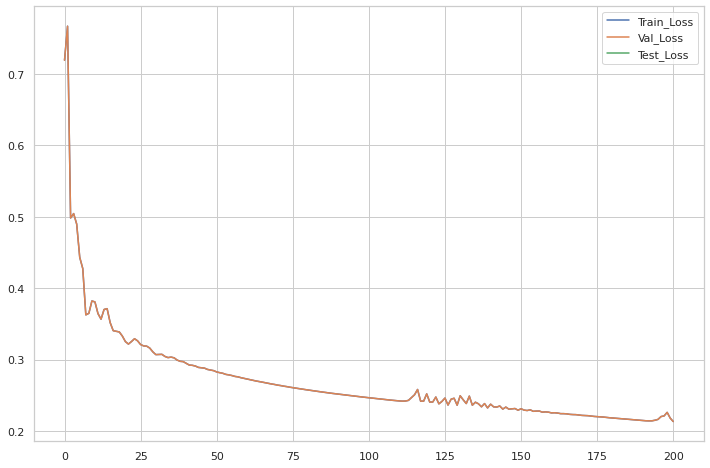

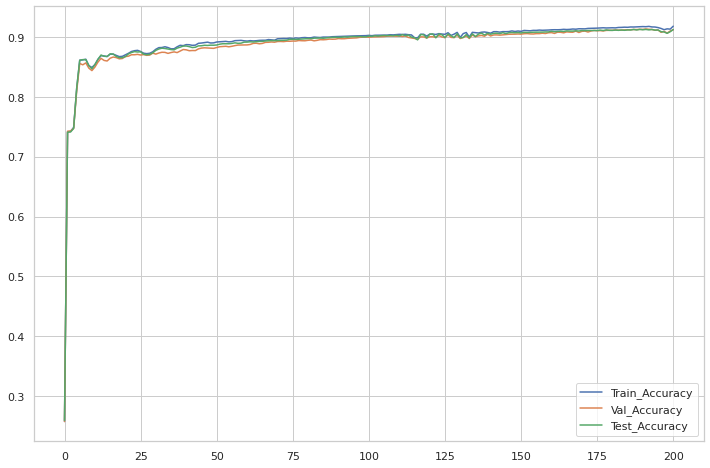

In [120]:
num_of_feat=g.num_node_features
net=SocialGNN(num_of_feat=num_of_feat,f=12)
criterion=nn.CrossEntropyLoss()
train_social(net,g,epochs=200,lr=0.1)

O modelo GNN simples foi baseado em GNN convolucional na estrutura PyTorch usando a extensão torch_geometric.
Além disso, um próximo passo seria verificar outras camadas GNN que o torch_geometric oferece. 